In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlos_core.optimizers
import ConfigSpace as CS
from ConfigSpace import UniformIntegerHyperparameter
from ConfigSpace import UniformFloatHyperparameter
from ConfigSpace import CategoricalHyperparameter

In [2]:
def cost_model(index):
    performance_data = pd.read_csv('../../build/performance/performance_metrics.csv', header=None, names=["empty_reads", "non_empty_reads", "range_reads", "writes"])
    #print(index,[performance_data.iloc[index:index+10].mean().sum()])
    return [performance_data.iloc[index:].mean().sum()]

In [3]:
# Start defining a ConfigurationSpace for the Optimizer to search.
input_space = CS.ConfigurationSpace(seed=1234)

# Add a single continuous input dimension between 0 and 1.
input_space.add_hyperparameter(CS.Integer("target_file_size_base", (2,100000000), default=2))


target_file_size_base, Type: UniformInteger, Range: [2, 100000000], Default: 2

In [4]:
#input_space.add_hyperparameter(CS.Float("max_bytes_for_level_multiplier", (1,10000), default=10))

In [5]:
# Choose an optimizer.

#optimizer = mlos_core.optimizers.RandomOptimizer(parameter_space=input_space)

#optimizer = mlos_core.optimizers.FlamlOptimizer(parameter_space=input_space)

optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)

In [6]:
optimizer

SmacOptimizer(space_adapter=None)

In [7]:
import os
import time
import sys
def pass_values_to_interface(new_val):
    #print(new_val)
    pipe_path = '../../build/passing_params_pipe'
    if not os.path.exists(pipe_path):
        os.mkfifo(pipe_path)
    pipe_fd = os.open(pipe_path, os.O_RDWR)
    data =''
    try:
        for x in new_val:
            data+='\n' + x + '=' + str(new_val[x].iloc[0])
            #print(str(new_val[x].iloc[0]))
        #data = ('max_write_buffer_number' + '=' + str(int(new_val['target_file_size_base'])* 1048576) + '\n' + 'target_file_size_multiplier' + '=' + str(new_val['target_file_size_multiplier']) + '\n').encode('utf-8')
        #data = ('target_file_size_multiplier' + '=' + str(new_val['target_file_size_multiplier']) + '\n').encode('utf-8')
        #data = "\n max_write_buffer_number=2 \n max_bytes_for_level_multiplier=10.0 \n "
        data=data.encode('utf-8')
        os.write(pipe_fd, data)
        sys.stdout.flush()
    except KeyboardInterrupt:
        pass
#     finally:
#         os.close(pipe_fd)


In [8]:
def read_epochs_pipe():
    while True:
        epochs_pipe_path = '../../build/passing_epochs'
        if os.path.exists(epochs_pipe_path):
            epochs_pipe_fd = os.open(epochs_pipe_path, os.O_RDONLY)
            try:
                buffer_size = 128
                buffer = os.read(epochs_pipe_fd, buffer_size).decode('utf-8')
                if buffer:
                    reported_epochs = int(buffer)
                    print(f"Reported epochs: {reported_epochs}")
                    return reported_epochs
                    # Process the reported epochs as needed
            except OSError as e:
                if e.errno == os.errno.EAGAIN or e.errno == os.errno.EWOULDBLOCK:
                    # No data available to read, ignore
                    pass
                else:
                    raise
            finally:
                os.close(epochs_pipe_fd)
        else:
            #print(f"The passing_epochs pipe '{epochs_pipe_path}' does not exist.")
            pass
    


In [ ]:
def run_optimization():
    # get a new config value suggestion to try from the optimizer.
    suggested_value = optimizer.suggest()
    pass_values_to_interface(suggested_value)
    # evaluate target function
    #time.sleep(30)

    index=read_epochs_pipe()
    time.sleep(30)
    target_value = cost_model(index)
    print("suggested_value",suggested_value)
    print("target value",target_value)
    optimizer.register(suggested_value, target_value)

# run for some iterations
n_iterations = 30
for i in range(n_iterations):
    run_optimization()

In [ ]:
optimizer.get_observations()

In [27]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['target_file_size_multiplier','target_file_size_base'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot the true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
# alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
# t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
# ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
# value = surrogate_predictions['predicted_value']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.experiment_designer.utility_function(optimization_problem.construct_feature_dataframe(pd.DataFrame({'x': line}))), ':', label='utility_function')
plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()
plt.show()

RuntimeError: Surrogate model can make predictions *only* after all initial points have been evaluated 0 <= 10

In [11]:
optimizer.get_best_observation()

,x,score
0,0.758504,-6.019895


In [28]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

          x
0  0.249426
          x
0  0.127631
          x
0  0.825619
         x
0  0.05359
          x
0  0.281399
          x
0  0.620541
          x
0  0.800754
          x
0  0.232957
         x
0  0.72763
          x
0  0.623661
          x
0  0.015894
          x
0  0.276474
          x
0  0.941073
          x
0  0.017465
          x
0  0.523295
          x
0  0.799587
          x
0  0.145099
          x
0  0.784602
          x
0  0.926411
          x
0  0.069283
          x
0  0.662156
          x
0  0.474467
          x
0  0.787014
          x
0  0.454093
          x
0  0.347766
          x
0  0.995873
          x
0  0.289056
        x
0  0.2385
          x
0  0.546177
          x
0  0.136686
          x
0  0.382862
          x
0  0.825687
          x
0  0.861957
          x
0  0.095579
          x
0  0.470425
          x
0  0.766471
          x
0  0.828939
          x
0  0.677623
          x
0  0.543587
          x
0  0.291881
          x
0  0.968028
          x
0  0.168481


In [13]:
optimizer.get_best_observation()

,x,score
0,0.757249,-6.02074


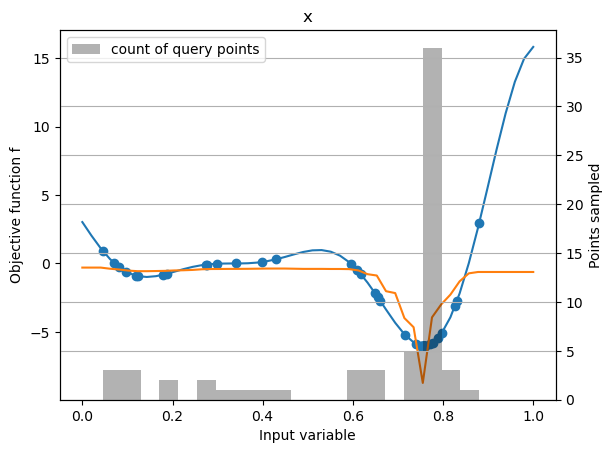

In [14]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=columns=['target_file_size_multiplier','target_file_size_base'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
#ci_raduii = surrogate_predictions['prediction_ci']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')

ax = plt.gca()
ax.set_ylabel("Objective function f")
ax.set_xlabel("Input variable")
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
pd.DataFrame(observations.x).hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of query points")
plt.legend()

In [ ]:
hyper_parameters_integer = {
    "max_open_files":[-1,10000, -1],
    "max_total_wal_size":[0, 100000, 0],
    "delete_obsolete_files_period_micros":[0, 6 * 60 * 60 * 1000000, 6 * 60 * 60 * 1000000],
    "max_background_jobs":[2, 10, 2],
    "max_subcompactions":[1, 100, 1],
    "compaction_readahead_size":[0, 1000000, 0],
    "writable_file_max_buffer_size":[0, 1024 * 1024, 1024 * 1024],
    "delayed_write_rate":[0, 1000000, 0],
    
    "max_write_buffer_number":[1, 10, 2],
    "inplace_update_num_locks":[0, 10000, 0],
    "memtable_huge_page_size":[0, 1000000, 0],
    "arena_block_size":[0, 1000000, 0],
    "level0_slowdown_writes_trigger":[0, 100, 20],
    "level0_stop_writes_trigger":[0, 100, 36],
    "target_file_size_base":[0, 100000000, 64 * 1048576],
    "target_file_size_multiplier":[0, 100, 1],
    "max_compaction_bytes":[0, 1000000000, 64 * 1048576 * 25],
    "soft_pending_compaction_bytes_limit":[0, 1000000000, 64 * 1073741824],
    "hard_pending_compaction_bytes_limit":[0, 1000000000, 256 * 1073741824]                          
}
                                           
hyper_parameters_float ={
    "memtable_prefix_bloom_size_ratio":[0.0, 1.0, 0.0],
    "max_bytes_for_level_multiplier":[0.0, 100.0, 10.0]
}
                                           
hyper_parameters_catagorical ={
    "avoid_flush_during_shutdown":[[True, False],False],  
    "memtable_whole_key_filtering":[[True, False],False],
   "compression_per_level":[["kNoCompression", "kSnappyCompression", "kZlibCompression", "kBZip2Compression", "kLZ4Compression", "kLZ4HCCompression", "kXpressCompression", "kZSTD"], "kNoCompression"]

}